# Pattern Recognition - HW1 - Mohammad Doosti Lakhani - 98722278 
In this notebook, I have implemented the first assignment which contains following sections in brief:
0. Making Things Ready to Go!
1. Interacting With Dataset (via Pandas)
2. Preprocessing
    1. Cleansing via Regex
    2. Stemming (via NLTK)
    3. Lemmatiation (via NLTK)
    4. Stopwords (via NLTK)
3. Feature Extraction
    1. Bag of Words
    2. BERT Embeddings (via [Sentence-Transoformers](https://github.com/UKPLab/sentence-transformers))
    3. TF-IDF (via sklearn)
    4. Word2Vec
4. Model Training (via sklearn)
    1. Naive Bayes
        1. Linear
        2. Polynomial
        3. Gaussian
    2. SVM
        1. SVC
        2. Linear SVC
    3. Decision Tree
    4. Random Forest
5. Metrics
    1. Accuracy
    2. Precision
    3. Recall
    4. F1
    5. ROC_AUC (via sklearn)

Note: Each section will be discussed adequately in its particular part.
Note: Functions documentations has almost all needed info about their job intuitively.

## 0 Making Things Ready to Go
This step contains following steps:
1. Installing necessary packages (Note default packages on Colab has not been considered)
2. Downloading and unziping dataset
3. Downloading necessary files for NLTK

### 0.1 Installing necessary packages

In [ ]:
!pip install -U sentence-transformers
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

### 0.2 Downloading and unziping dataset

In [ ]:
!tar -xvzf aclImdb_v1.tar.gz

### 0.1 Downloading necessary files for NLTK

In [17]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

!TCMALLOC_LARGE_ALLOC_REPORT_THRESHOLD=20000000000  # use this line to prevent colab fram crashing because of low memory

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1 Interacting With Dataset
This step consists of following sections:
1. Reading a single review files (testing purposes)
2. Reading Entire Train or Test set and their labels
3. Reading train data
4. Reading test data

In [ ]:
import os
import glob

from typing import List

import pandas as pd
import numpy as np

### 1.1 Reading a single file
`read_single_file(path: str) -> pd.DataFrame` method will do the job for us. And it returns a pandas Dataframe with only one row that contains the review text in it.

In [ ]:
def read_single_file(path: str) -> pd.DataFrame:
    """
    Reads only a file containing the review

    :param path: path to the file
    :return: a pandas `DataFrame`
    """
    with open(path) as file:
        review = [file.read()]
    return pd.DataFrame(review, columns=['text'])

### 1.2 Reading entire dataset
`def read_all_files(path: str, shuffle: bool = True) -> pd.DataFrame` will do two things for us:
1. Reading data: Reads all files in `pos` and `neg` folders of given `train` or `test` folder and returns a dataframe that columns contains `text` and `labels` of reviews. 
2. Shuffling it: Shuffling data is necessary to make sure model are not learning the spatial pattern instead of features' patterns.

In [ ]:
def read_all_files(path: str, shuffle: bool = True) -> pd.DataFrame:
    """
    Reads all files in the the given folder `path`

    :param path: A str "path/" to the folder containing all files ("data/train") sub folder of classes will be handled
    :param shuffle: shuffle the data order or not
    :return: a pandas `DataFrame['text', 'label']`
    """

    pos_reviews = []
    neg_reviews = []

    root_path = path
    pos_path = root_path + '/pos/*.txt'
    files = glob.glob(pos_path)

    if len(files) == 0:
        raise Exception('The path:"{}" contains no file to be read.'.format(path))

    for name in files:
        with open(name) as f:
            pos_reviews.append(f.read())
    neg_path = root_path + '/neg/*.txt'
    files = glob.glob(neg_path)
    for name in files:
        with open(name) as f:
            neg_reviews.append(f.read())

    labels = np.zeros(len(pos_reviews + neg_reviews), dtype=np.int)
    labels[0:len(pos_reviews)] = 1

    pos_reviews.extend(neg_reviews)
    del neg_reviews

    data_frame = pd.DataFrame(pos_reviews, columns=['text'])
    data_frame['label'] = labels

    if shuffle:
        data_frame = data_frame.sample(frac=1).reset_index(drop=True)  # note the operation is in-place
        return data_frame
    return data_frame

### 1.3 Reading train data

In [28]:
root = 'aclImdb/train'
df = read_all_files(root, True)
df.head(5)

,text,label
0,"I had fun watching this movie, mainly due to S...",1
1,I got in to this excellent program in about se...,1
2,This is a film that makes you say 2 things... ...,0
3,MULHOLLAND DRIVE made me the definitive fan of...,1
4,"Recently, I had opportunity to view a working ...",0


Here is a sample of train set. First column corresponds to the text of a review and the second column contains its label which 1 is positive and 0 is negative.

### 1.4 Reading test data

In [19]:
root = 'aclImdb/test'
df = read_all_files(root, True)
df.head(5)

,text,label
0,A variation of the same plot line was used in ...,1
1,I can name only a few movies that I have seen ...,0
2,"Soderbergh is a fabulous director, but nothing...",1
3,"Back in the cold and creepy early 90's,a show ...",0
4,"Each show is excellent. Finally, a show about ...",1


## 2 Preprocessing
This step means making our data ready and cleaned to be able to be fed to models.
The data we are using is the reviews obtained using web crawler from IMDB movie reviews webpage, so the content has noises such as html tags. But also we do not need all forms of words or all punctuation marks. 

After this cleansing procedure, we need to represent our words/sentences using numbers (numbers are needed for training procedure) and between possible methods we are using BOW, BERT, TF-IDF and Word2Vec (each will be explained in their own section).

Following steps, take care of these issues:
1. Bag of words
    1. Generate Vocabulary
    2. Filter Vocabulary
    3. Tokenizer
    4. Build BOW
2. BERT
    1. Constants
    2. Tokenizer
3. TF-IDF

4. Get BOW, BERT, TF-IDF
    1. BOW
    2. BERT
    3. TF-IDF

In [ ]:
import pandas as pd
import numpy as np
import operator

from typing import Dict, List, Tuple

import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer

### 2.1 Bag of Words
Let's talk about BOW. The whole idea about BOW is so simple. We extract all words we have in our universe and count them (in our case all reviews), then we go back and check each review that each word how many times has been occured in that particular review. Note that you can use binary form which 1 is when word exists in that review and 0 for non-existant word.

After doing this for each review, we have a vector of binary/integer values with size of our whole vocabulary database(our universe words.)

#### 2.1.1 Generate Vocabulary
We need all the vocabs in all reviews to build a equal-length rows for all reviews. We also save their occurences so we can filter out those are too frequent or rare.



In [ ]:
def generate_vocabulary(df: pd.DataFrame, save: bool = False, path: str = None,
                        names: Tuple[str] = ('text', 'label')) -> Dict:
    """
    Gets a pandas `DataFrame` and extracts all word occurrence in the entries of the `df` and build a dictionary
    that each word's number of repetition in whole texts.

    :param df: a pandas DataFrame with a column called 'text' to be analyzed.
    :param save: Whether or not saving dictionary as a file in disc
    :param path: Only applicable if `save` is True. The path which contains name of file to save vocab.
    :param names: A tuple of strings containing key values of "feature" and "label" in the dataframes
    :return: A dictionary of words and their counts
    """
    vocabulary = {}
    for reviews in df[names[0]]:
        for word in reviews:
            if word not in vocabulary.keys():
                vocabulary[word] = 1
            else:
                vocabulary[word] += 1
    if save:
        with open(path, 'w+') as file:
            for k, v in zip(vocabulary.keys(), vocabulary.values()):
                file.write(str(k) + ' ' + str(v) + '\n')
    return vocabulary


def read_vocabulary(path: str) -> Dict:
    """
    Reads saved vocabulary at the path as a dictionary

    :param path: path to file of vocabs
    :return: A dictionary of words and their frequencies
    """

    vocab = {}
    with open(path) as file:
        line = file.readline()
        while line:
            key, value = line.split(' ')
            vocab[key] = int(value)
            line = file.readline()
    return vocab

#### 2.1.2 Filter Vocabulary
Filtering vocabulary enable us to omit those which are outliers like rare ones or the most commons. Between all reviews, the word 'film' may has occured a lot. Now the question is that is this word and its huge count informative for us? No! because the dataset is about movie revies and for sure word 'movie` has no information.

This logic can be used for rarefied words too.


In [ ]:
def filter_vocabulary(vocab: Dict, threshold: float, bidirectional: bool):
    """
    Applies a filter regarding given arguments and return a subset of given vocab dictionary.

    Methods:
    1. threshold = -1: no cutting
    2. 0 < threshold <1 : cuts percentage=`threshold` of data
    3. 2 < threshold < len(vocab): cuts `threshold` number of words

    Note: in all cases output is sorted dictionary.

    :param vocab: A `Dict` of vocabularies where keys are words and values are int of repetition.
    :param threshold: a float or int number in specified format.
    :param bidirectional: Cutting process will be applied on most frequent and less frequent if `True`, else
            only less frequent.
    :return: A sorted `Dict` based on the values
    """
    # convert percentage to count
    if threshold <= 1:
        threshold = int(threshold) * 100
        threshold *= len(vocab)

    # sort vocab
    sorted_vocab = {k: v for k, v in sorted(vocab.items(), key=operator.itemgetter(1))}

    if threshold < 0:
        return sorted_vocab

    # filter
    if bidirectional:
        sorted_vocab = dict(list(sorted_vocab.items())[threshold:-threshold])
        return sorted_vocab
    else:
        sorted_vocab = dict(list(sorted_vocab.items())[threshold:])
        return sorted_vocab


#### 2.1.3 BOW Tokenizer
Tokenizing step means converting texts into proper forms regarding considered model. This task can be done using following steps:
1. Extracting Words: In this step, we extract sentences then words using some regex to omit html characters, removing punctuations, etc.
2. Stopwords: But we do not have to extract all words. We can omit those which have no particular meaning like preposisitions or auxiliary verbs such as 'a', 'the'. 
3. Normalizing: Like stemming or lematization. In simple words, converting tokenized words into words than can represent different form of the words. For instance, 'seems' and 'seem' both have same meaning and there is no reason to discreminate them.
    1. Using hard-coded rules: In this situation, we just use some grammatical rules, etc to normalize words.
    2. WordNet: Like always, we prefer machine extracted feature than hard-coded rules.

In [ ]:
def tokenizer(text: str, omit_stopwords: bool = True, root: str = 'lem') -> List[str]:
    """
    Tokenizes a review into sentences then words using regex

    :param text: a string to be tokenized
    :param omit_stopwords: whether remove stopwords or not using NLTK
    :param root: using `stemming`, `lemmatization` or none of them to get to the root of words ['lem', 'stem', 'none']
    :return: a `List` of string
    """

    # inits
    words = []
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    strings = re.sub(r'((<[ ]*br[ ]*[/]?[ ]*>)[ ]*)+', '\n', text).lower().split('\n')
    for line in strings:
        # remove punctuations
        line = line.translate(str.maketrans('', '', string.punctuation))
        words_of_line = re.sub(r'[\d+.]+', '', line.strip()).split(' ')  # remove numbers
        for w in words_of_line:
            if omit_stopwords:
                if w in stopwords.words('english'):
                    continue

            if root == 'none':  # no stemming or lemmatization
                pass
            elif root == 'lem':  # lemmatization using WordNet (DOWNLOAD NEEDED)
                w = lemmatizer.lemmatize(w)
            elif root == 'stem':  # stemming using Porter's algorithm
                w = stemmer.stem(w)
            else:
                raise Exception('root mode not defined. Use "lem", "stem" or "none"')
            if len(w) > 0:
                words.append(w)
    return words

#### 2.1.4 Build BOW
Now we have our filtered dic of vocabs, we can build {0, 1} array for each review instead of the words where 1 means word exists in that review and vice versa. (We need numerical representation for SVM, Naive Bayes, etc).

I have used 0, 1 because it has lowest possible information about word frequencies. The reason is that BERT has maxmimum context for each word and TF-IDF has much more info about words in relation to BOW and this huge distance between these models enable us to see the huge difference in validation accuracy too.

In [ ]:
def build_bow(words: List[str], vocabulary: Dict):
    """
    Build Bag of Words model for given `List` of words regarding given `vocabulary` dictionary.

    :param words: A list of words to be converted to BOW
    :param vocabulary: A list of vocabulary as reference
    :return: A `List` of int
    """
    return np.array([1 if wv in words else 0 for wv in vocabulary], dtype=np.int8)


### 2.2 BERT
To understand what is BERT and how it works please read the paper, but different packages handle the interaction with model almost in same way except a few details.
If I want to summarize its logic, it consider the context for each word using the sentence(words) that surrounded the main word and gives a float number to each word.
Here I will explain about transfroms method.

#### 2.2.1 Constants
All punctions in BOW model has been removed but in BERT, some of the need to be exist, such as '?', '!', '.',',', etc. 

In [ ]:
PUNCTUATION = r""""#$%&()'*+-./<=>@[\]^_`{|}~"""

#### 2.2.2 BERT Tokenizer
1. Case: BERT model has been trained case-sensitive and uncased. But I used uncased version.
2. Converting reviews to sentences: We need to convert reviews into sentences and putting `[CLS]` at the begining and `[SEP]` at the end of each sentence. But this has been handled using package.
3. Extract values using pretrained BERT: As it does not directly related to NLP, I have omited the explanation.
4.  Padding: BERT will give you a 1-dimensional tensor for a sentence with the shape of `(1, 724)`. The bigger one model give us `(1, 1024)`.
5. Now we have a `(1, 724)` vector for each sentence of each review. But each review contains many phrases so what I have done is taking mean column-wise. This enable us to have the mean magnitude of the whole phrases. Note that this approach has been used to get mean magnitude of the sentence using its word too.

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

def bert_tokenizer(text: str, model = model):
    """
    Preprocesses the input in BERT convention and use BERT tokenizer to tokenize and convert words to
    IDs. In the end, we obtain hidden layers' values using PyTorch and pad all of them to have same
    sized tensors to apply average at the end of process for each review.

    example:

    input: "Hi Nik. How you doing?"
    1. preprocessed: "[CLS] hi nik . [SEP] how you doing ? [SEP]"
    2. tokenization
    3. convert to IDs
    4. model values
    5. padding
    6. average row-wise (each row corresponds to a sentence of a review)

    :param text: a string to be tokenized
    :param pretrained: Which pretrained model to use
    :return: A string in BERT  convention
    """

    text = text.lower()
    strings = re.sub(r'((<[ ]*br[ ]*[/]?[ ]*>)[ ]*)+', ' ', text).split(r'. ')
    review_avg = np.empty(((len(strings), 768)))
    for idx, s in enumerate(strings):
        strings[idx] = strings[idx].translate(str.maketrans('', '', PUNCTUATION))
    sentence_embeddings = model.encode(strings)

    for idx, s in enumerate(sentence_embeddings):
        review_avg[idx] = s

    return review_avg.mean(axis=0).astype(np.float64)

### 2.3 TF-IDF
This step, aims to convert words to number using numbers using their frequencies etc. But how?

In BOW model I have used 0, 1 weighting. You can use pure frequency too. But we know that all words cannot have same weights because some of them has more information (something like the logic we used for `filter_vocabulary` method.)

TF-IDF consists of both word frequency and document frequency. It means TF-IDF enable us to see how much important the word is to a document in the whole corpus.

TF-IDF has two terms to be calculated as its name indicates it.
1. Term Frequency: `TF=(# of occurence of word T/# words in document)`
2. Inverse Document Frequency: `IDF=(log(exp(# docs/# docs containing word T))`

In summary, term 1 enable us to find out dominant words in each document, meanwhile term 2 enable us to weigh redundent ones down and weigh up the important ones.

Here are the step for this purposes:

1. Tokenizer
2. Build TF-IDF

#### 2.3.1 Tokenizer
I use same tokenizer I have used for BOW, because extracting words, normalizing them, etc all are same for TF-IDF.

In [ ]:
def tokenizer(text: str, omit_stopwords: bool = True, root: str = 'lem') -> List[str]:
    """
    Tokenizes a review into sentences then words using regex

    :param text: a string to be tokenized
    :param omit_stopwords: whether remove stopwords or not using NLTK
    :param root: using `stemming`, `lemmatization` or none of them to get to the root of words ['lem', 'stem', 'none']
    :return: a `List` of string
    """

    # inits
    words = []
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    strings = re.sub(r'((<[ ]*br[ ]*[/]?[ ]*>)[ ]*)+', '\n', text).lower().split('\n')
    for line in strings:
        # remove punctuations
        line = line.translate(str.maketrans('', '', string.punctuation))
        words_of_line = re.sub(r'[\d+.]+', '', line.strip()).split(' ')  # remove numbers
        for w in words_of_line:
            if omit_stopwords:
                if w in stopwords.words('english'):
                    continue

            if root == 'none':  # no stemming or lemmatization
                pass
            elif root == 'lem':  # lemmatization using WordNet (DOWNLOAD NEEDED)
                w = lemmatizer.lemmatize(w)
            elif root == 'stem':  # stemming using Porter's algorithm
                w = stemmer.stem(w)
            else:
                raise Exception('root mode not defined. Use "lem", "stem" or "none"')
            if len(w) > 0:
                words.append(w)
    return words

#### 2.3.2 Build TF-IDF


In [ ]:
def build_tf_idf(df: pd.DataFrame, custom_tokenizer: callable = tokenizer, names: Tuple[str] = ('text', 'label'),
                 **kwargs):
    """
    Builds TF-IDF embeddings for given corpus in a DataFrame

    :param df: a pandas DataFrame
    :param custom_tokenizer: A custom tokenizer function to replace default one
    :param names: A tuple of strings containing key values of "feature" and "label" in the dataframes
    :param kwargs: Optional parameters of object
    :return: (A numpy ndarray object containing the features of given corpus, fitted vectorizer)
    """
    vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, **kwargs)
    x = vectorizer.fit_transform(df[names[0]].to_numpy())
    return x.toarray(), vectorizer

### 2.4 Get BOW, BERT, TF-IDF values
In this step we just get those values.

Something we need to be aware is that sklearn model packages need 2-D input for x and 1-D for y. So in each step we have a reshape.

Note: Sometimes, we can see that I have casted data dtype and the reason is the limitation of memory. For instance, for BOW or Tf-IDF, default type is float64 and it will take about 15GB data, So I reduce it to float16 to only take about 3GB.

1. BOW
2. BERT
3. TF-IDF

#### 2.4.1 Get BOW

In [ ]:
df['text'] = df['text'].apply(tokenizer)
vocabs = read_vocabulary('vocab.vocab')
filtered_vocab = filter_vocabulary(vocabs, 40000, False)
print(df.head(5))
df['text'] = df['text'].apply(build_bow, args=(filtered_vocab,))

In [ ]:
df['text'] = df['text'].apply(np.reshape, args=((1, -1),))
x = np.concatenate(df['text'].to_numpy(), axis=0)
y = df['label'].to_numpy().astype(np.int8)
x = x.astype(np.int8)

Note: As colab may crash due to RAM issues, I save values to save time.

In [ ]:
np.save('x_test_bow', x)
np.save('y_test_bow', y)

In [ ]:
x = np.load('x_train.npy')
y = np.load('y_train.npy')

#### 2.4.2 GET BERT

In [ ]:
df['text'] = df['text'].apply(bert_tokenizer)
print(df.head(5))

                                                text  label
0  [-0.04469093028455973, 0.22785229980945587, 1....      1
1  [-0.08899574565629546, 0.6020955696272162, 0.9...      0
2  [-0.16736593780418238, 0.41776339632148546, 0....      1
3  [0.017716815126025014, 0.15603996813297272, 0....      1
4  [0.22297563622979558, 0.33016353927771835, 0.9...      1


In [ ]:
df['text'] = df['text'].apply(np.reshape, args=((1, -1),))
x = np.concatenate(df['text'].to_numpy(), axis=0)
y = df['label'].to_numpy().astype(np.int8)

In [ ]:
np.save('x_test_bert', x)
np.save('y_test_bert', y)

#### 2.4.3 GET TF-IDF
I think  have to mention two poins here:
1. I used 2-gram model: 1-gram model is just considering each word separately from the other ones like BOW model. But 2-gram model gets any combination of words that can build a 2-word term.

2. I used `max_features=60000` as I have previously encountered errors related to memory issues (time is small around 20 to 40 mintues). Using a low value such this, may degrade the performance immensly.

In [ ]:
x, tfidf_vec_fitted = build_tf_idf(df, tokenizer, lowercase=False, analyzer='word', ngram_range=(1,2), max_features=60000)
y = df['label'].to_numpy().astype(np.int8)
x = x.astype(np.float16)

In [ ]:
with open('tfidf_vec_fitted.model', 'rb') as f:
    tfidf_vec_fitted = pickle.load(f)

In [ ]:
# in test mode just transform not fit the TF-IDF vectorizer
x_test = tfidf_vec_fitted.transform(df['text'].to_numpy())
y_test = df['label'].to_numpy().astype(np.int8)
x_test = x_test.toarray()
x_test = x_test.astype(np.float16)

In [ ]:
np.save('x_test_tfidf', x_test)
np.save('y_test_tfidf', y_test)
# pickle.dump(tfidf_vec_fitted, open('tfidf_vec_fitted.model', 'wb'))

In [ ]:
x = np.load('x_train_tfidf.npy')
y = np.load('y_train_tfidf.npy')

## 3 Training Models
In this step we build 4 type of models for our BOW, BERT, TF-IDF and Word2vec embeddings.
1. Naive Bayes
2. SVM
3. Decision Tree
4. Random Forest

Note: As the data is huge and we do not have any infrastructure to run our codes, only linear svc in SVM can converge for BOW and TF-IDF model.


In [ ]:
# %% import libraries
import numpy as np
import pandas as pd
import pickle

from typing import Dict
from sklearn.naive_bayes import BaseNB
from sklearn.svm import base

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# from sentiment_analysis.utils import F, IO


# %% constants and inits
class BAYES_MODELS:
    """
    Enum of possible models
    """
    GAUSSIAN = 1
    POLYNOMIAL = 2
    BERNOULLI = 3


class SVM_MODELS:
    """
    Enum of possible models
    """
    SVC = 1
    LINEAR_SVC = 2


# %% functions
def build_svm(model_type: int, x: np.ndarray, y: np.ndarray, svc_kernel: str = None, save: bool = True,
              path: str = None, **kwargs) -> base:
    """
    Trains a SVM model

    :param model_type: The kernel of SVM model (see `SVM_MODELS` class)
    :param svc_kernel: The possible kernels for `SVC` model (It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’)
    It will be ignored if `model_type = LINEAR_SVC`
    :param x: Features in form of numpy ndarray
    :param y: Labels in form of numpy ndarray
    :param save: Whether save trained model on disc or not
    :param path: Path to save fitted model
    :param kwargs: A dictionary of other optional arguments of models in format of {'arg_name': value} (ex: {'C': 2})
    :return:A trained VSM model
    """
    if model_type == SVM_MODELS.SVC:
        model = SVC(kernel=svc_kernel, **kwargs)
    elif model_type == SVM_MODELS.LINEAR_SVC:
        model = LinearSVC(**kwargs)
    else:
        raise Exception('Model {} is not valid'.format(model_type))

    model.fit(x, y)

    if save:
        if path is None:
            path = ''
        pickle.dump(model, open(path + model.__module__ + '.model', 'wb'))
    return model


def build_bayes(model_type: int, x: np.ndarray, y: np.ndarray, save: bool = True, path: str = None, **kwargs) -> BaseNB:
    """
    Trains a naive bayes model

    :param model_type: The kernel of Naive Bayes model (see `BAYES_MODELS` class)
    :param x: Features in form of numpy ndarray
    :param y: Labels in form of numpy ndarray
    :param save: Whether save trained model on disc or not
    :param path: Path to save fitted model
    :return: A trained Naive Bayes model
    """

    if model_type == BAYES_MODELS.GAUSSIAN:
        model = GaussianNB(**kwargs)
    elif model_type == BAYES_MODELS.BERNOULLI:
        model = BernoulliNB(binarize=None, **kwargs)
    elif model_type == BAYES_MODELS.POLYNOMIAL:
        model = MultinomialNB(**kwargs)
    else:
        raise Exception('Kernel type "{}" is not valid.'.format(model_type))

    model.fit(x, y)

    if save:
        if path is None:
            path = ''
        pickle.dump(model, open(path + model.__module__ + '.model', 'wb'))
    return model


def build_decision_tree(x: np.ndarray, y: np.ndarray, save: bool = True,
                        path: str = None, **kwargs) -> DecisionTreeClassifier:
    """
    Trains a Decision Tree model

    :param x: Features in form of numpy ndarray
    :param y: Labels in form of numpy ndarray
    :param save: Whether save trained model on disc or not
    :param path: Path to save fitted model
    :return: A trained Decision Tree model
    """
    model = DecisionTreeClassifier(**kwargs)

    model.fit(x, y)

    if save:
        if path is None:
            path = ''
        pickle.dump(model, open(path + model.__module__ + '.model', 'wb'))
    return model


def build_random_forest(x: np.ndarray, y: np.ndarray, save: bool = True,
                        path: str = None, **kwargs) -> RandomForestClassifier:
    """
    Trains a Random Forest model

    :param x: Features in form of numpy ndarray
    :param y: Labels in form of numpy ndarray
    :param save: Whether save trained model on disc or not
    :param path: Path to save fitted model
    :return: A trained Random Forest model
    """
    model = RandomForestClassifier(**kwargs)

    model.fit(x, y)

    if save:
        if path is None:
            path = ''
        pickle.dump(model, open(path + model.__module__ + '.model', 'wb'))
    return model

In [ ]:
# svc_linear = build_svm(model_type=SVM_MODELS.LINEAR_SVC, x=x, y=y, max_iter=20000, path='tfidf_')
# bayes = build_bayes(BAYES_MODELS.POLYNOMIAL, x, y, True, path='tfidf_')
# svc_rbf = build_svm(model_type=SVM_MODELS.SVC, x=x, y=y, svc_kernel='rbf', path='tfidf_svc_rbf_')
# dt = build_decision_tree(x=x, y=y, path='tfidf_')
# rf = build_random_forest(x=x, y=y, path='tfidf_rf100_',n_estimators=100)

## 4 Metrics
In this step, we compare different trained models regarding BOW or BERT embeddings using information can be gained from confusion matrix such as Accuracy, F1 Score, AUC.

The metrics have been covered:
1. Accuracy
2. Precision
3. Recall
4. F1
5. ROC Graph
6. AUC Score

This section consists of following steps:
1. BOW
    1. Linear SVC
    2. Gaussian Naive Bayes
    3. Decision Tree (Gini)
    4. Random Forest (100 Estimators)
2. BERT
    1. Linear SVC
    2. Gaussian Naive Bayes
    3. Decision Tree (Gini)
    4. Random Forest (100 Estimators)
    5. Random Forest (10 Estimators)
3. TF-IDF
    1. Linear SVC
    2. Gaussian Naive Bayes
    3. Decision Tree (Gini)
    4. Random Forest (100 Estimators)

### 4.0 Metrics
Let's explain the metrics here to omit duplicate explanation in comparison of models' results.

0. Confusion Matrix
1. Accuracy
2. Precision
3. Recall
4. F1
5. ROC Graph
6. AUC Score

#### 4.0.0 Confusion Matrix
Becaus all other metircs can be calculated, we first introduce confusion matrix.

Our confusion matrix is like this image:

![confusion matrix](wiki/cm.jpg)

Where:

* `TN = True Negative`
* `FP = False Positive`
* `FN = False Negative`
* `TP = True Positive`

#### 4.0.1 Accuracy
Accuracy is how our model can say class 1 is 1 and 0 is 0 regarding all given examples.

Give confusion matrix,

`Accuracy = (TN+TP) / (TN+FP+FN+TP)`

So obviously more is better.

#### 4.0.2 Precision
Based on confusion matrix,

`precision = TP / (FP+TP)`

Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. High precision relates to the low false positive rate. In our case, it says between all those we labeled as positive, how many of the are actually positive.

#### 4.0.3 Recall
Based on confusion matrix,

`recall = TP / (TP+FN)`

Recall is the ratio of correctly predicted positive observations to the all observations in actual positive class.
In our case, Between all label is positive, how many we said positive.

#### 4.0.4 F1 Score
Based on available values,

`F1 = 2*(Recall * Precision) / (Recall + Precision)`
F1 score is weighted average of precision and recall, so it is very usefull when the cost of error of classes are different from each other (say disease detection).


#### 4.0.5 ROC-AUC
Let's talk about ROC using AUC value as these are seamlessly interchangable.

AUC is the area under ROC graph. More AUC says our model is more powerful to distinguish between the two classes. AUC = 0.5 says our model almost failed to differentiate. AUC = 1 is perfect model.

For plotting we need two values:
1. `TPR = TP / (TP + FN)`
2. `FPR = FP / (FP + TN)` 

Now we compare these values regarding different classification thresholds. Increasing threshold label more entries as positive so it increases both `FP` and `TP`.

AUC is the aggregated measure of performance among all possible thresholds.

In [ ]:
# %% import libraries
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

from typing import Tuple, List


# %% functions
def accuracy(cm: np.ndarray) -> float:
    """
    Calculates accuracy using given confusion matrix

    :param cm: Confusion matrix in form of np.ndarray
    :return: A float number
    """
    true = np.trace(cm)
    false = np.sum(cm) - true
    ac = true / (true + false)
    return ac


def precision(cm: np.ndarray) -> np.ndarray:
    """
    Precision of the model using given confusion matrix

    :param cm: Confusion matrix in form of np.ndarray
    :return: A list of precisions with size of number of classes
    """
    tp = np.diag(cm)
    tpp = np.sum(cm, axis=0)
    with np.errstate(divide='ignore', invalid='ignore'):
        p = np.true_divide(tp, tpp)
        p[~ np.isfinite(p)] = 0
        p = np.nan_to_num(p)
    return p


def recall(cm: np.ndarray) -> np.ndarray:
    """
    Recall of the model using given confusion matrix

    :param cm: Confusion matrix in form of np.ndarray
    :return: A list of recalls with size of number of classes
    """
    tp = np.diag(cm)
    tap = np.sum(cm, axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        r = np.true_divide(tp, tap)
        r[~ np.isfinite(r)] = 0
        r = np.nan_to_num(r)
    return r


def f1(cm: np.ndarray) -> float:
    """
    F1 score of the model using given confusion matrix

    :param cm: Confusion matrix in form of np.ndarray
    :return: A float number
    """
    p = precision(cm)
    r = recall(cm)
    with np.errstate(divide='ignore', invalid='ignore'):
        f = np.true_divide(p * r, p + r)
        f[~ np.isfinite(f)] = 0
        f = np.nan_to_num(f)
    return f * 2


def roc_auc(true, pred, plot=False) -> Tuple[float, Tuple[List[float], List[float], List[float]]]:
    """
    Calculates AUC and ROC on binary data

    :param true: True labels
    :param pred: Predicted labels
    :param plot: Whether or not plot the ROC curve
    :return: A tuple of (AUC value, ROC curve values)
    """
    fpr, tpr, th = roc_curve(true, pred, pos_label=1)
    auc = roc_auc_score(true, pred)
    if plot:
        plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
        plt.show()
    return auc, (fpr, tpr, th)

### 4.1 BOW
1. Linear SVC
2. Gaussian Naive Bayes
3. Decision Tree
4. Random Forest (100 Estimators)
5. Random Forest (10 Estimators)

In [ ]:
x_test = np.load('drive/My Drive/IUST-PR/HW1/BOW/x_test_bow.npy')
y_test = np.load('drive/My Drive/IUST-PR/HW1/BOW/y_test_bow.npy')

#### 4.1.1 Linear SVC

Accuracy = 0.75296
Precision = 0.7529666313684613
Recall =  0.75296
F1 Score =  0.7529583809880456


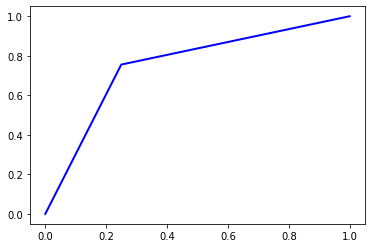

AUC Score =  0.75296


In [ ]:
with open('drive/My Drive/IUST-PR/HW1/BOW/sklearn.svm.classes.model', 'rb') as f:
    linear_svc_bow = pickle.load(f)

pred = linear_svc_bow.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

#### 4.1.2 Gaussian Naive Bayes

Accuracy = 0.5022
Precision = 0.5024223332828854
Recall =  0.5022
F1 Score =  0.4905091253839987


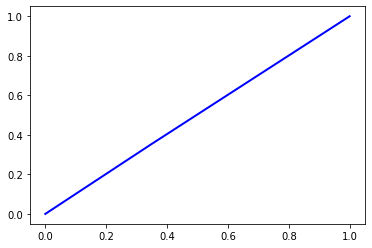

AUC Score =  0.5022


In [ ]:
with open('drive/My Drive/IUST-PR/HW1/BOW/sklearn.naive_bayes.model', 'rb') as f:
    gaussian_bayes_bow = pickle.load(f)

pred = gaussian_bayes_bow.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

#### 4.1.3 Decision Tree

Accuracy = 0.69924
Precision = 0.6992592934006392
Recall =  0.6992400000000001
F1 Score =  0.6992327195069016


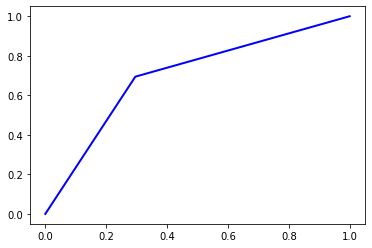

AUC Score =  0.69924


In [ ]:
with open('drive/My Drive/IUST-PR/HW1/BOW/sklearn.tree.tree.model', 'rb') as f:
    dt_bow = pickle.load(f)

pred = dt_bow.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

#### 4.1.4 Random Forest (100 estimators)

Accuracy = 0.80596
Precision = 0.8062815220906299
Recall =  0.80596
F1 Score =  0.8059090627744345


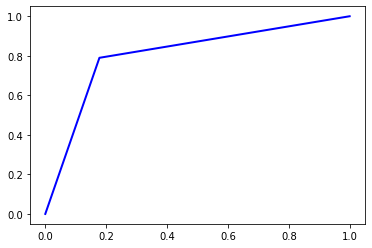

AUC Score =  0.80596


In [ ]:
with open('drive/My Drive/IUST-PR/HW1/BOW/sklearn.ensemble.forest.bow.100est.modelsklearn.ensemble.forest.model', 'rb') as f:
    dt_bow = pickle.load(f)

pred = dt_bow.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

#### 4.1.5 Random Forest (10 Estimators)

Accuracy = 0.7082
Precision = 0.7154237918813569
Recall =  0.7081999999999999
F1 Score =  0.7057330917675375


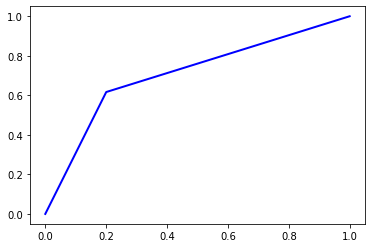

AUC Score =  0.7081999999999999


In [ ]:
with open('drive/My Drive/IUST-PR/HW1/BOW/sklearn.ensemble.forest.model', 'rb') as f:
    dt_bow = pickle.load(f)

pred = dt_bow.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

### 4.2 BERT
1. Linear SVC
2. Bernoulli Naive Bayes
3. Gaussian Naive Bayes
4. Decision Tree
5. Random Forest
6. RBF SVM

In [ ]:
x_test = np.load('x_test_bert.npy')
y_test = np.load('y_test_bert.npy')

#### 4.2.1 Linear SVC

Accuracy = 0.9006
Precision = 0.9006003102248803
Recall =  0.9006
F1 Score =  0.9005999807561562


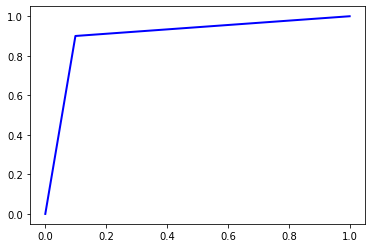

AUC Score =  0.9006


In [ ]:
pred = svc_linear.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

#### 4.2.2 Bernoulli Naive Bayes

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:955: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))


Accuracy = 0.5
Precision = 0.25
Recall =  0.5
F1 Score =  0.3333333333333333


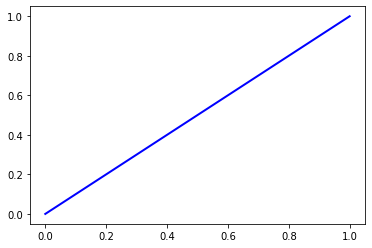

AUC Score =  0.5


In [ ]:
pred = bayes.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

#### 4.2.3 Gaussian Naive Bayes

Accuracy = 0.83844
Precision = 0.8389758725843917
Recall =  0.83844
F1 Score =  0.8383761239167881


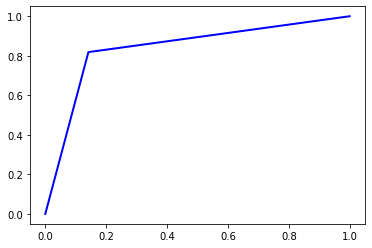

AUC Score =  0.83844


In [ ]:
with open('bert_sklearn.naive_bayes.model', 'rb') as f:
    gaussian_bayes = pickle.load(f)

pred = gaussian_bayes.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

#### 4.2.4 Decision Tree (Gini)

Accuracy = 0.7826
Precision = 0.782600406944586
Recall =  0.7826
F1 Score =  0.7825999217359719


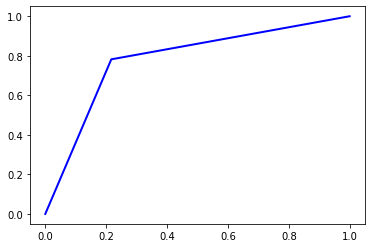

AUC Score =  0.7826


In [ ]:
pred = dt.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

#### 4.2.5 Random Forest (Gini - 100 Estimators)

Accuracy = 0.86172
Precision = 0.8617219469322073
Recall =  0.86172
F1 Score =  0.8617198139301816


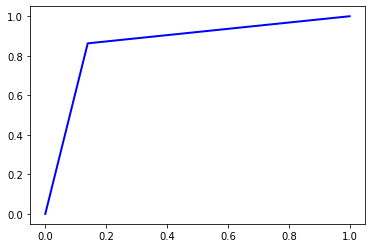

AUC Score =  0.86172


In [ ]:
pred = rf.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

####4.2.6 RBF SVM

Accuracy = 0.88256
Precision = 0.882572692843774
Recall =  0.88256
F1 Score =  0.8825590258975844


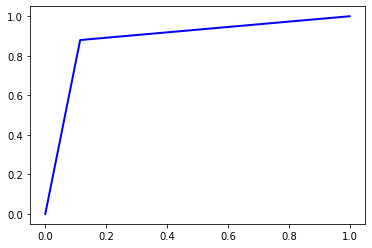

AUC Score =  0.88256


In [ ]:
pred = svc.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

### 4.3 TF-IDF
1. Linear SVC
2. Polynomial (Degree=3) Naive Bayes
3. Decision Tree
4. Random Forest (100 Estimators)

In [ ]:
x_test = np.load('x_test_tfidf.npy')
y_test = np.load('y_test_tfidf.npy')

#### 4.3.1 Linear SVC

Accuracy = 0.88348
Precision = 0.8836042877892437
Recall =  0.88348
F1 Score =  0.8834705611154504


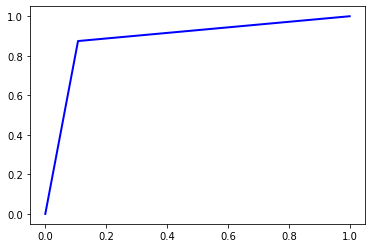

AUC Score =  0.88348


In [27]:
with open('tfidf_svc_linear.model', 'rb') as f:
    svc_linear = pickle.load(f)
pred = svc_linear.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

#### 4.3.2 Polynomial (Degree=3) Naive Bayes

Accuracy = 0.85868
Precision = 0.8595847243718886
Recall =  0.85868
F1 Score =  0.8585910528672362


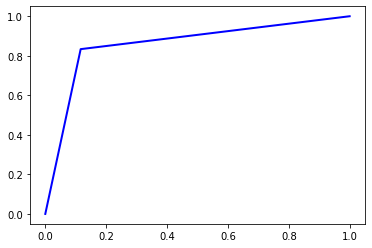

AUC Score =  0.8586800000000001


In [26]:
with open('tfidf_pnb.model', 'rb') as f:
    pnb = pickle.load(f)
pred = pnb.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

#### 4.3.3 Decision Tree (gini)

Accuracy = 0.7142
Precision = 0.7142108592909853
Recall =  0.7142
F1 Score =  0.7141963778392142


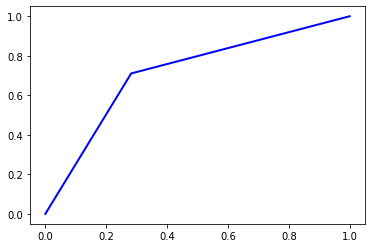

AUC Score =  0.7142


In [22]:
with open('tfidf_dt.model', 'rb') as f:
    dt = pickle.load(f)
pred = dt.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

#### 4.3.4 Random Forest (100 Estimators)

Accuracy = 0.85384
Precision = 0.8540958464299427
Recall =  0.85384
F1 Score =  0.8538135938231812


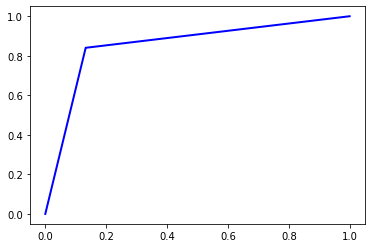

AUC Score =  0.85384


In [21]:
with open('tfidf_rf100.model', 'rb') as f:
    rf = pickle.load(f)
pred = rf.predict(x_test)
cm = confusion_matrix(y_test, pred)
print('Accuracy =', accuracy(cm))
print('Precision =', precision(cm).mean())
print('Recall = ', recall(cm).mean())
print('F1 Score = ', f1(cm).mean())
print('AUC Score = ', roc_auc(y_test, pred, True)[0])

## 5 INTERACTING WITH GOOGLE DRIVE

In [42]:
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo

Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [ ]:
from colab_util import *
drive_handler = GoogleDriveHandler()

In [25]:
ID = drive_handler.path_to_id('IUST-PR/HW1')
# drive_handler.list_folder(ID, max_depth=1)
drive_handler.upload('x_test_tfidf.npy', parent_path='IUST-PR/HW1')
drive_handler.upload('y_test_tfidf.npy', parent_path='IUST-PR/HW1')
# drive_handler.upload('tfidf_rf100.model', parent_path='IUST-PR/HW1')
# drive_handler.upload('sklearn.ensemble.forest.model', parent_path='IUST-PR/HW1')
# drive_handler.upload('tfidf_pnb.model', parent_path='IUST-PR/HW1')
# drive_handler.upload('tfidf_dt.model', parent_path='IUST-PR/HW1')
# drive_handler.upload('tfidf_svc_linear.model', parent_path='IUST-PR/HW1')
# drive_handler.upload('svc_rbf_sklearn.svm.classes.model', parent_path='IUST-PR/HW1')
# drive_handler.upload('tfidf_vec_fitted.model', parent_path='IUST-PR/HW1')

'1fuYSW4_-tgLm6i7QHHQB_1v9MPO33F8Q'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')